In [1]:
setwd("/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.3_Cluster Distribution Analyses/Input")
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.3_Cluster Distribution Analyses/Output')
curdate = "112520"

library("readxl")
library(factoextra)
library(missForest)
#library(plyr) #this must be loaded before tidyverse
library(tidyverse)
library(janitor)
library(reshape2)
library(car) #package necessary to run anova and specify type III errors

#subject characteristics
subjectinfo <-  read.csv("SubjectInfo_102920.csv")

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: foreach

Loading required package: itertools

Loading required package: iterators

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate()    masks foreach::accumulate()
✖ dplyr::combine()       masks randomForest::combine()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::lag()           masks stats::lag()
✖ randomForest::margin() masks ggplot2::margin()
✖ purr

First obtaining the eigencytokines.

In [2]:
#### Recoding subject characteristic values  
subjectinfo$Sex <- ifelse(subjectinfo$Sex=="M", 1, 0) #coding Males as 1, Females as 0
subjectinfo$Ethnicity <- ifelse(subjectinfo$Ethnicity=="NH", 0, 1) #coding NH as 0, H as 1

#make categorical variables factors 
subjectinfo$Race <- factor(subjectinfo$Race, levels=c("W", "AA", "As", "O"))
subjectinfo$Group <- factor(subjectinfo$Group, levels=c("NS", "CS", "Ecig"))

In [3]:
#upload cytokine data for each compartment 
ELF_cyto <- read.csv("ELF_NonNorm_110220.csv")
NLF_cyto <- read.csv("NLF_NonNorm_110220.csv")
Serum_cyto <- read.csv("Serum_NonNorm_110220.csv")
Sputum_cyto <- read.csv("Sputum_NonNorm_110220.csv")

#transpose cytokine data for each compartment
ELF_cyto <- as.data.frame(t(ELF_cyto)) %>% 
  row_to_names(row_number = 1)
NLF_cyto <- as.data.frame(t(NLF_cyto)) %>% 
  row_to_names(row_number = 1)
Serum_cyto <- as.data.frame(t(Serum_cyto)) %>% 
  row_to_names(row_number = 1)
Sputum_cyto <- as.data.frame(t(Sputum_cyto)) %>% 
  row_to_names(row_number = 1)

#cluster assignments for each compartment 
ELF_clus <- read.csv("ELF_cluster_assignments.csv")
NLF_clus <- read.csv("NLF_cluster_assignments.csv")
Serum_clus <- read.csv("Serum_cluster_assignments.csv")
Sputum_clus <- read.csv("Sputum_cluster_assignments.csv")

#renaming first column, grouping and splitting by "Cluster" column
ELF_clus <- ELF_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split
NLF_clus <- NLF_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split
Serum_clus <- Serum_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split
Sputum_clus <- Sputum_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split

#making dfs for each cluster for PCA analysis 
ELF_1 <- ELF_clus[[1]]
ELF_2 <- ELF_clus[[2]]
ELF_3 <- ELF_clus[[3]]

NLF_1 <- NLF_clus[[1]]
NLF_2 <- NLF_clus[[2]]
NLF_3 <- NLF_clus[[3]]

Serum_1 <- Serum_clus[[1]]
Serum_2 <- Serum_clus[[2]]
Serum_3 <- Serum_clus[[3]]

Sputum_1 <- Sputum_clus[[1]]
Sputum_2 <- Sputum_clus[[2]]
Sputum_3 <- Sputum_clus[[3]]

#making df with subjects' cytokine concentration data for each cluster 
ELF_1 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
ELF_2 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
ELF_3 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

NLF_1 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
NLF_2 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
NLF_3 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

Serum_1 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Serum_2 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Serum_3 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

Sputum_1 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Sputum_2 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Sputum_3 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

#PCA on each cluster, eigenvectors are in rotation -- PROBLEM - for some reason had to convert everything to numeric  
pca_ELF_1 <- ELF_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_ELF_2 <- ELF_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_ELF_3 <- ELF_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>%   
  prcomp()

pca_NLF_1 <- NLF_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_NLF_2 <- NLF_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_NLF_3 <- NLF_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

pca_Serum_1 <- Serum_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Serum_2 <- Serum_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Serum_3 <- Serum_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

pca_Sputum_1 <- Sputum_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Sputum_2 <- Sputum_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Sputum_3 <- Sputum_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

#eigenvector dfs of first principal component 
eigencytokines_ELF_1 <- data.frame(pca_ELF_1$rotation[,"PC1"])
  colnames(eigencytokines_ELF_1)[1] <- "Cluster1"
eigencytokines_ELF_2 <- data.frame(pca_ELF_2$rotation[,"PC1"])
  colnames(eigencytokines_ELF_2)[1] <- "Cluster2"
eigencytokines_ELF_3 <- data.frame(pca_ELF_3$rotation[,"PC1"])
  colnames(eigencytokines_ELF_3)[1] <- "Cluster3"

eigencytokines_NLF_1 <- data.frame(pca_NLF_1$rotation[,"PC1"])
  colnames(eigencytokines_NLF_1)[1] <- "Cluster1"
eigencytokines_NLF_2 <- data.frame(pca_NLF_2$rotation[,"PC1"])
  colnames(eigencytokines_NLF_2)[1] <- "Cluster2"
eigencytokines_NLF_3 <- data.frame(pca_NLF_3$rotation[,"PC1"])
  colnames(eigencytokines_NLF_3)[1] <- "Cluster3"
  
eigencytokines_Serum_1 <- data.frame(pca_Serum_1$rotation[,"PC1"])
  colnames(eigencytokines_Serum_1)[1] <- "Cluster1"
eigencytokines_Serum_2 <- data.frame(pca_Serum_2$rotation[,"PC1"])
  colnames(eigencytokines_Serum_2)[1] <- "Cluster2"
eigencytokines_Serum_3 <- data.frame(pca_Serum_3$rotation[,"PC1"])
  colnames(eigencytokines_Serum_3)[1] <- "Cluster3"

eigencytokines_Sputum_1 <- data.frame(pca_Sputum_1$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_1)[1] <- "Cluster1"
eigencytokines_Sputum_2 <- data.frame(pca_Sputum_2$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_2)[1] <- "Cluster2"
eigencytokines_Sputum_3 <- data.frame(pca_Sputum_3$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_3)[1] <- "Cluster3"
  

#collapse all eigencytokine dfs
eigencytokines_ELF <- cbind(eigencytokines_ELF_1, eigencytokines_ELF_2, eigencytokines_ELF_3)
eigencytokines_NLF <- cbind(eigencytokines_NLF_1, eigencytokines_NLF_2, eigencytokines_NLF_3)
eigencytokines_Serum <- cbind(eigencytokines_Serum_1, eigencytokines_Serum_2, eigencytokines_Serum_3)
eigencytokines_Sputum <- cbind(eigencytokines_Sputum_1, eigencytokines_Sputum_2, eigencytokines_Sputum_3)

#scale all eigencytokine dfs
eigencytokines_ELF_scaled <- as.data.frame(scale(eigencytokines_ELF))
eigencytokines_NLF_scaled <- as.data.frame(scale(eigencytokines_NLF))
eigencytokines_Serum_scaled <- as.data.frame(scale(eigencytokines_Serum))
eigencytokines_Sputum_scaled <- as.data.frame(scale(eigencytokines_Sputum))

Warning message in row_to_names(., row_number = 1):
“Row 1 does not provide unique names. Consider running clean_names() after row_to_names().”
Warning message:
“The `.data` argument of `add_column()` must have unique names as of tibble 3.0.0.
Use `.name_repair = "minimal"`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [4]:
head(eigencytokines_NLF_scaled)

,Cluster1,Cluster2,Cluster3
,<dbl>,<dbl>,<dbl>
CS_15,0.59627288,0.9146567,-0.4217487
CS_16,0.53333725,-1.3452712,0.1464940
CS_17,-0.33340986,-1.2136276,0.3649891
CS_18,-0.03844361,0.6639576,1.0542413
CS_19,1.24339651,-3.1775608,0.1557776
CS_20,-1.26478002,-0.1840008,0.3135186


# One-way ANOVA

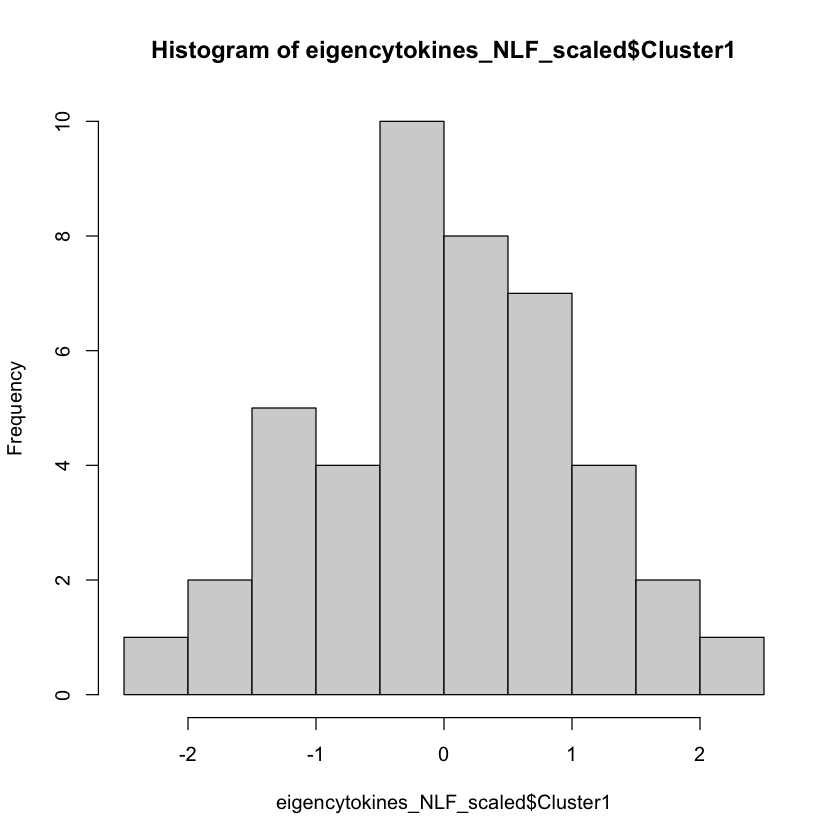

In [5]:
#testing for normality
hist(eigencytokines_NLF_scaled$Cluster1)

In [6]:
#adding a col to designate smoking status 
eigen_NLF_scaled = eigencytokines_NLF_scaled %>%
    rownames_to_column("SubjectID") %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster1, Cluster2, Cluster3, Group, Age)
eigen_ELF_scaled = eigencytokines_ELF_scaled %>%
    rownames_to_column("SubjectID") %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster1, Cluster2, Cluster3, Group, Age)
eigen_Sputum_scaled = eigencytokines_Sputum_scaled %>%
    rownames_to_column("SubjectID") %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster1, Cluster2, Cluster3, Group, Age)
eigen_Serum_scaled = eigencytokines_Serum_scaled %>%
    rownames_to_column("SubjectID") %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster1, Cluster2, Cluster3, Group, Age)

Joining, by = "SubjectID"

Joining, by = "SubjectID"

Joining, by = "SubjectID"

Joining, by = "SubjectID"



In [7]:
head(eigen_NLF_scaled)

,SubjectID,Cluster1,Cluster2,Cluster3,Group,Age
,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,CS_15,0.59627288,0.9146567,-0.4217487,CS,34
2,CS_16,0.53333725,-1.3452712,0.1464940,CS,33
3,CS_17,-0.33340986,-1.2136276,0.3649891,CS,24
4,CS_18,-0.03844361,0.6639576,1.0542413,CS,33
5,CS_19,1.24339651,-3.1775608,0.1557776,CS,29
6,CS_20,-1.26478002,-0.1840008,0.3135186,CS,25


In [8]:
#now I can run the anova comparing each group to one another within each cluster
#contrasts show what compartments are being compared in anova
#these comparisons aren't what we want so I changed them in the function below
contrasts(eigen_NLF_scaled$Group)

,CS,Ecig
NS,0,0
CS,1,0
Ecig,0,1


                 Table of Contrasts
>                   NS    | CS  |  Ecig  |  Sum
>     Contrast 1 |  -1    |  1  |   0    |   0
>     Contrast 2 |  -1    |  0  |   1    |   0

> - Contrast 1: compares NS to CS
> - Contrast 2: compares NS to Ecig

In [9]:
get_anova1 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is specified above
    anova = aov(Cluster1~Group, data = scaled_df)
    return(anova)
}
get_anova2 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is specified above
    anova = aov(Cluster2~Group, data = scaled_df)
    return(anova)
}

get_anova3 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is specified above
    anova = aov(Cluster3~Group, data = scaled_df)
    return(anova)
}


#calling fn
NLF_Cluster1_anova = get_anova1(eigen_NLF_scaled)
NLF_Cluster2_anova = get_anova2(eigen_NLF_scaled)
NLF_Cluster3_anova = get_anova3(eigen_NLF_scaled)
ELF_Cluster1_anova = get_anova1(eigen_ELF_scaled)
ELF_Cluster2_anova = get_anova2(eigen_ELF_scaled)
ELF_Cluster3_anova = get_anova3(eigen_ELF_scaled)
Sputum_Cluster1_anova = get_anova1(eigen_Sputum_scaled)
Sputum_Cluster2_anova = get_anova2(eigen_Sputum_scaled)
Sputum_Cluster3_anova = get_anova3(eigen_Sputum_scaled)
Serum_Cluster1_anova = get_anova1(eigen_Serum_scaled)
Serum_Cluster2_anova = get_anova2(eigen_Serum_scaled)
Serum_Cluster3_anova = get_anova3(eigen_Serum_scaled)

In [10]:
#viewing results
summary(NLF_Cluster1_anova)
summary(NLF_Cluster2_anova)
summary(NLF_Cluster3_anova)
summary(ELF_Cluster1_anova)
summary(ELF_Cluster2_anova)
summary(ELF_Cluster3_anova) #this was the only that was even close to being significant
summary(Sputum_Cluster1_anova)
summary(Sputum_Cluster2_anova)
summary(Sputum_Cluster3_anova)
summary(Serum_Cluster1_anova)
summary(Serum_Cluster2_anova)
summary(Serum_Cluster3_anova)

            Df Sum Sq Mean Sq F value Pr(>F)
Group        2   1.47  0.7345   0.725   0.49
Residuals   41  41.53  1.0129               

            Df Sum Sq Mean Sq F value Pr(>F)
Group        2   1.35  0.6754   0.665   0.52
Residuals   41  41.65  1.0158               

            Df Sum Sq Mean Sq F value Pr(>F)
Group        2   0.65  0.3264   0.316  0.731
Residuals   41  42.35  1.0329               

            Df Sum Sq Mean Sq F value Pr(>F)
Group        2   1.34  0.6724   0.662  0.521
Residuals   41  41.66  1.0160               

            Df Sum Sq Mean Sq F value Pr(>F)
Group        2   0.49  0.2438   0.235  0.792
Residuals   41  42.51  1.0369               

            Df Sum Sq Mean Sq F value Pr(>F)  
Group        2   5.79  2.8972   3.193 0.0514 .
Residuals   41  37.21  0.9075                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)
Group        2   0.75  0.3768   0.366  0.696
Residuals   41  42.25  1.0304               

            Df Sum Sq Mean Sq F value Pr(>F)
Group        2   1.69  0.8455   0.839  0.439
Residuals   41  41.31  1.0075               

            Df Sum Sq Mean Sq F value Pr(>F)
Group        2   0.06  0.0289   0.028  0.973
Residuals   41  42.94  1.0474               

            Df Sum Sq Mean Sq F value Pr(>F)
Group        2    0.9  0.4478   0.429  0.654
Residuals   40   41.8  1.0451               

            Df Sum Sq Mean Sq F value Pr(>F)
Group        2   0.66  0.3315   0.331   0.72
Residuals   40  40.04  1.0011               

            Df Sum Sq Mean Sq F value Pr(>F)
Group        2   0.52   0.262   0.247  0.782
Residuals   40  42.39   1.060               

In [11]:
# Tukey's post hoc
NLF_Cluster1_tukey_anova = TukeyHSD(NLF_Cluster1_anova, type = 'III')
NLF_Cluster2_tukey_anova = TukeyHSD(NLF_Cluster2_anova, type = 'III')
NLF_Cluster3_tukey_anova = TukeyHSD(NLF_Cluster3_anova, type = 'III')
ELF_Cluster1_tukey_anova = TukeyHSD(ELF_Cluster1_anova, type = 'III')
ELF_Cluster2_tukey_anova = TukeyHSD(ELF_Cluster2_anova, type = 'III')
ELF_Cluster3_tukey_anova = TukeyHSD(ELF_Cluster3_anova, type = 'III')
Sputum_Cluster1_tukey_anova = TukeyHSD(Sputum_Cluster1_anova, type = 'III')
Sputum_Cluster2_tukey_anova = TukeyHSD(Sputum_Cluster2_anova, type = 'III')
Sputum_Cluster3_tukey_anova = TukeyHSD(Sputum_Cluster3_anova, type = 'III')
Serum_Cluster1_tukey_anova = TukeyHSD(Serum_Cluster1_anova, type = 'III')
Serum_Cluster2_tukey_anova = TukeyHSD(Serum_Cluster2_anova, type = 'III')
Serum_Cluster3_tukey_anova = TukeyHSD(Serum_Cluster3_anova, type = 'III')

# ANCOVA

In [12]:
#controlling for age
get_ancova_age1 = function(scaled_df){
    #don't need anymore
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1))#meaning is explained above
    ancova = aov(Cluster1~Age+Group, data = scaled_df)
    return(ancova)
}
get_ancova_age2 = function(scaled_df){
    #don't need anymore
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is explained above
    ancova = aov(Cluster2~Age+Group, data = scaled_df)
    return(ancova)
}
get_ancova_age3 = function(scaled_df){
    #don't need anymore
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is explained above
    ancova = aov(Cluster3~Age+Group, data = scaled_df)
    return(ancova)
}

#calling fn
NLF_Cluster1_ancova_age = get_ancova_age1(eigen_NLF_scaled)
NLF_Cluster2_ancova_age = get_ancova_age2(eigen_NLF_scaled)
NLF_Cluster3_ancova_age = get_ancova_age3(eigen_NLF_scaled)
ELF_Cluster1_ancova_age = get_ancova_age1(eigen_ELF_scaled)
ELF_Cluster2_ancova_age = get_ancova_age2(eigen_ELF_scaled)
ELF_Cluster3_ancova_age = get_ancova_age3(eigen_ELF_scaled)
Sputum_Cluster1_ancova_age = get_ancova_age1(eigen_Sputum_scaled)
Sputum_Cluster2_ancova_age = get_ancova_age2(eigen_Sputum_scaled)
Sputum_Cluster3_ancova_age = get_ancova_age3(eigen_Sputum_scaled)
Serum_Cluster1_ancova_age = get_ancova_age1(eigen_Serum_scaled)
Serum_Cluster2_ancova_age = get_ancova_age2(eigen_Serum_scaled)
Serum_Cluster3_ancova_age = get_ancova_age3(eigen_Serum_scaled)

In [13]:
#viewing results
summary(NLF_Cluster1_ancova_age)
summary(NLF_Cluster2_ancova_age)
summary(NLF_Cluster3_ancova_age)
summary(ELF_Cluster1_ancova_age)
summary(ELF_Cluster2_ancova_age)
summary(ELF_Cluster3_ancova_age)
summary(Sputum_Cluster1_ancova_age)
summary(Sputum_Cluster2_ancova_age)
summary(Sputum_Cluster3_ancova_age)
summary(Serum_Cluster1_ancova_age)
summary(Serum_Cluster2_ancova_age)
summary(Serum_Cluster3_ancova_age)

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.47  0.4658   0.456  0.503
Group        2   1.72  0.8592   0.842  0.438
Residuals   40  40.82  1.0204               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.51  0.5109   0.493  0.487
Group        2   1.02  0.5094   0.491  0.615
Residuals   40  41.47  1.0368               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.00  0.0029   0.003  0.959
Group        2   0.66  0.3305   0.312  0.734
Residuals   40  42.34  1.0584               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.07  0.0675   0.065  0.800
Group        2   1.39  0.6961   0.670  0.517
Residuals   40  41.54  1.0385               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.71  0.7087   0.682  0.414
Group        2   0.74  0.3685   0.355  0.704
Residuals   40  41.55  1.0389               

            Df Sum Sq Mean Sq F value Pr(>F)  
Age          1   0.58  0.5789   0.623  0.435  
Group        2   5.23  2.6149   2.812  0.072 .
Residuals   40  37.19  0.9298                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.48  0.4791   0.457  0.503
Group        2   0.57  0.2845   0.271  0.764
Residuals   40  41.95  1.0488               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.67  0.6659    0.66  0.421
Group        2   2.00  0.9985    0.99  0.380
Residuals   40  40.34  1.0084               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   1.57  1.5705   1.533  0.223
Group        2   0.45  0.2248   0.219  0.804
Residuals   40  40.98  1.0245               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.82  0.8237   0.783  0.382
Group        2   0.87  0.4365   0.415  0.663
Residuals   39  41.00  1.0514               

            Df Sum Sq Mean Sq F value Pr(>F)  
Age          1   3.27   3.272   3.571 0.0662 .
Group        2   1.70   0.848   0.926 0.4047  
Residuals   39  35.74   0.916                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)  
Age          1   3.57   3.571   3.705 0.0616 .
Group        2   1.76   0.878   0.911 0.4105  
Residuals   39  37.59   0.964                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [14]:
library(multcomp)

Loading required package: mvtnorm

Warning message:
“package ‘mvtnorm’ was built under R version 4.0.3”
Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser




In [16]:
# Tukey's post hoc
NLF_Cluster1_tukey_ancova = glht(NLF_Cluster1_ancova_age, linfct=mcp(Group = "Tukey")) 
summary(NLF_Cluster1_tukey_ancova)


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = Cluster1 ~ Age + Group, data = scaled_df)

Linear Hypotheses:
                Estimate Std. Error t value Pr(>|t|)
CS - NS == 0   -0.425026   0.389173  -1.092    0.524
Ecig - NS == 0 -0.433080   0.377954  -1.146    0.492
Ecig - CS == 0 -0.008054   0.387683  -0.021    1.000
(Adjusted p values reported -- single-step method)
